# 05a4 – E3SFCA Capacity Scenario Runner

This notebook applies the Enhanced 3-Step Floating Catchment Area (E3SFCA) method to evaluate CT access under baseline and expansion scenarios.

---

### Purpose

We compare population-level CT scanner accessibility under four capacity scenarios:

- **Baseline** (existing Acute + CDC sites)
- **+5% capacity** (4 new sites, 1 scanner each)
- **+10% capacity** (6 new sites, 2×2, 4×1 scanners)
- **+20% capacity** (8 new sites, 2 scanners each)

---

### Input Files

- LSOA population + demand (`gdf_lsoa_CT_accessibility_2024.gpkg`)
- LSOA-to-LSOA travel matrix (`LSOA_to_LSOA_complete.csv`)
- Site capacity files (baseline + uplift scenarios in `E3SFCA_Scenarios/`)
- NHS CT capability reference files (Acute, CDC)

---

### Outputs

- Accessibility scores (`Fi`) for each LSOA per scenario
- Supply-to-demand (`Rj`) for each site
- Visual 2×2 maps comparing scenario impacts
- Scenario outputs exported to GPKG and CSV


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import mapclassify
import warnings

warnings.filterwarnings("ignore")


In [37]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs (MRI)
# ----------------------------------------------------------
import os

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files (MRI)
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_MRI_accessibility_2024.gpkg")
lsoa_gpkg_path   = os.path.join(processed_dir, "LSOA_MRI_Demand_with_Demographics_2024_v1.gpkg")

# Prefer densified OD; fall back to raw if not present
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete_densified.csv")
if not os.path.exists(travel_matrix_path):
    print("⚠️  Densified OD not found; using raw OD instead.")
    travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
print(f"Using travel matrix: {os.path.basename(travel_matrix_path)}")

# Reference site files (used for validation, not scenario runs)
cdc_path   = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Scenario MRI capacity files (with baseline sites already included)
scenario_dir = os.path.join(processed_dir, "E3SFCA_Scenarios")
scenario_files = {
    "Baseline": os.path.join(scenario_dir, "baseline_mri_sites.csv"),
    "+5%":      os.path.join(scenario_dir, "scenario_5pct_plus_baseline_mri.csv"),
    "+10%":     os.path.join(scenario_dir, "scenario_10pct_plus_baseline_mri.csv"),
    "+20%":     os.path.join(scenario_dir, "scenario_20pct_plus_baseline_mri.csv"),
}

# Output directory
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)




Using travel matrix: LSOA_to_LSOA_complete_densified.csv


In [4]:
# ----------------------------------------------------------
# Step 2 – Load Travel Matrix and LSOA Base Data (MRI)
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np

# --- Load the full LSOA-to-LSOA travel matrix (robust to header variants) ---
df_travel = pd.read_csv(travel_matrix_path)

# Normalise expected column names
rename_map = {}
if "origin_lsoa" in df_travel.columns:        rename_map["origin_lsoa"] = "origin_name"
if "dest_lsoa" in df_travel.columns:          rename_map["dest_lsoa"] = "destination_name"
if "car_travel_minutes" in df_travel.columns: rename_map["car_travel_minutes"] = "travel_time_car"
df_travel = df_travel.rename(columns=rename_map)

required_cols = {"origin_name", "destination_name", "travel_time_car"}
missing = required_cols - set(df_travel.columns)
if missing:
    raise KeyError(f"Travel matrix missing columns: {missing}")

# Clean/standardise types
for c in ["origin_name", "destination_name"]:
    df_travel[c] = df_travel[c].astype(str).str.strip()
df_travel["travel_time_car"] = pd.to_numeric(df_travel["travel_time_car"], errors="coerce")

# Quick OD diagnostics
o_set = set(df_travel["origin_name"].unique())
d_set = set(df_travel["destination_name"].unique())
has_diag = (df_travel["origin_name"] == df_travel["destination_name"]).any()
diag_zero_share = (
    df_travel.loc[df_travel["origin_name"] == df_travel["destination_name"], "travel_time_car"]
    .eq(0).mean() if has_diag else np.nan
)
print("— OD QUICK CHECK —")
print(f"Unique origins: {len(o_set)} | destinations: {len(d_set)} | identical sets: {o_set == d_set}")
print(f"Rows: {len(df_travel):,} | has diagonal: {has_diag} | origin==dest zero share: {diag_zero_share:.3f}")
print(f"NaN times: {df_travel['travel_time_car'].isna().sum():,}")

# --- ≤60 view (used in E3SFCA calculations/plots) ---
df_travel_car = df_travel[df_travel["travel_time_car"] <= 60].copy()
print(f"Travel matrix (≤60 min): {df_travel_car.shape} | share ≤60: {len(df_travel_car)/max(1,len(df_travel)):.3f}")

# --- Load base LSOA GeoDataFrame with MRI demand + geometry ---
gdf_lsoa = gpd.read_file(lsoa_gpkg_path)
assert {"lsoa21cd", "mri_total_demand", "geometry"} <= set(gdf_lsoa.columns), \
       "Expected MRI columns missing from LSOA GPKG (need 'mri_total_demand')."
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()
print("LSOA base (MRI) shape:", gdf_lsoa.shape)

# Clean IDs in the ≤60 view (already normalised above; keep consistent)
df_travel_car["origin_name"] = df_travel_car["origin_name"].astype(str).str.strip()
df_travel_car["destination_name"] = df_travel_car["destination_name"].astype(str).str.strip()


— OD QUICK CHECK —
Unique origins: 3451 | destinations: 3451 | identical sets: True
Rows: 11,909,401 | has diagonal: True | origin==dest zero share: 1.000
NaN times: 0
Travel matrix (≤60 min): (2409234, 3) | share ≤60: 0.202
LSOA base (MRI) shape: (3451, 51)


In [5]:
# ----------------------------------------------------------
# Step 3 – Load All Scenario Site Files (MRI)
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd

scenario_dir = os.path.join(processed_dir, "E3SFCA_Scenarios")

scenario_files = {
    "Baseline": "baseline_mri_sites.csv",
    "+5%":      "scenario_5pct_plus_baseline_mri.csv",
    "+10%":     "scenario_10pct_plus_baseline_mri.csv",
    "+20%":     "scenario_20pct_plus_baseline_mri.csv",
}

scenario_site_data = {}

for label, fname in scenario_files.items():
    path = os.path.join(scenario_dir, fname)
    if not os.path.exists(path):
        print(f"⚠️  Missing scenario file for {label}: {path}")
        continue

    df_sites = pd.read_csv(path)

    # Normalise/expect columns
    rename_map = {}
    if "lsoa" in df_sites.columns and "lsoa21cd" not in df_sites.columns:
        rename_map["lsoa"] = "lsoa21cd"
    if "site_name" in df_sites.columns and "Site Name" not in df_sites.columns:
        rename_map["site_name"] = "Site Name"
    if "scanners" in df_sites.columns and "scanner_count" not in df_sites.columns:
        rename_map["scanners"] = "scanner_count"
    df_sites = df_sites.rename(columns=rename_map)

    required = {"Site Name", "lsoa21cd", "scanner_count"}
    missing = required - set(df_sites.columns)
    if missing:
        raise KeyError(f"{label}: required columns missing: {missing}")

    # Clean types/IDs
    df_sites = df_sites[df_sites["lsoa21cd"].notna()].copy()
    df_sites["lsoa21cd"] = df_sites["lsoa21cd"].astype(str).str.strip()
    df_sites["Site Name"] = df_sites["Site Name"].astype(str).str.strip()

    # Scanner count numeric (coerce), drop negatives
    df_sites["scanner_count"] = pd.to_numeric(df_sites["scanner_count"], errors="coerce")
    neg = (df_sites["scanner_count"] < 0).sum()
    if neg:
        print(f"⚠️  {label}: dropping {neg} rows with negative scanner_count")
        df_sites = df_sites[df_sites["scanner_count"] >= 0]
    df_sites["scanner_count"] = df_sites["scanner_count"].fillna(0)

    # De-duplicate per scenario by LSOA (keep first)
    before = len(df_sites)
    df_sites = df_sites.drop_duplicates(subset=["lsoa21cd"], keep="first")
    dupes_removed = before - len(df_sites)

    # Store
    scenario_site_data[label] = df_sites

    # Report
    print(f"{label:>8} – Loaded {len(df_sites):3} rows | unique LSOAs={df_sites['lsoa21cd'].nunique():3} "
          f"| dupes_removed={dupes_removed:2} | total_scanners={df_sites['scanner_count'].sum():.0f}")

# Build a baseline LSOA set for later plotting/exclusions
baseline_lsoa = set()
if "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"])

# (Optional) also include CDC/Acute LSOAs if those layers are loaded
if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty and "lsoa21cd" in cdc_gdf.columns:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty and "lsoa21cd" in acute_gdf.columns:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# Sanity: ensure site LSOAs exist in the LSOA layer (geometry join will work)
if isinstance(gdf_lsoa, gpd.GeoDataFrame) and not gdf_lsoa.empty:
    lsoa_all = set(gdf_lsoa["lsoa21cd"].astype(str))
    for label, df in scenario_site_data.items():
        missing_in_geom = sorted(set(df["lsoa21cd"]) - lsoa_all)
        if missing_in_geom:
            print(f"⚠️  {label}: {len(missing_in_geom)} site LSOAs not found in gdf_lsoa (sample): {missing_in_geom[:5]}")


Baseline – Loaded  31 rows | unique LSOAs= 31 | dupes_removed= 2 | total_scanners=70
     +5% – Loaded  35 rows | unique LSOAs= 35 | dupes_removed= 2 | total_scanners=74
    +10% – Loaded  37 rows | unique LSOAs= 37 | dupes_removed= 2 | total_scanners=78
    +20% – Loaded  39 rows | unique LSOAs= 39 | dupes_removed= 2 | total_scanners=86


In [6]:
# ----------------------------------------------------------
# Step 4 – Filter Travel Matrix to Scenario-Specific MRI Sites
# ----------------------------------------------------------

import numpy as np
import pandas as pd

# Ensure ID columns are strings (belt & braces)
df_travel_car["destination_name"] = df_travel_car["destination_name"].astype(str).str.strip()
df_travel_car["origin_name"]      = df_travel_car["origin_name"].astype(str).str.strip()

# Pre-compute sets for fast membership tests
all_dest_le60 = set(df_travel_car["destination_name"].unique())
all_orig_le60 = set(df_travel_car["origin_name"].unique())
all_lsoa_ids  = set(gdf_lsoa["lsoa21cd"].astype(str).str.strip().unique())

travel_matrices_by_scenario = {}

for label, df_sites in scenario_site_data.items():
    print(f"\nFiltering travel matrix for: {label}")

    # Requested destination LSOAs (MRI sites; deduped, string)
    mri_lsoa_codes = pd.Index(df_sites["lsoa21cd"].astype(str).str.strip()).unique()
    n_req = len(mri_lsoa_codes)

    # Which of those exist in the ≤60 matrix?
    matched = mri_lsoa_codes.intersection(all_dest_le60)
    missing = mri_lsoa_codes.difference(all_dest_le60)

    # Filter ≤60 min matrix to matched MRI destinations only
    df_filtered = df_travel_car[df_travel_car["destination_name"].isin(matched)].copy()

    # Coverage by destination (how many origins ≤60 for each MRI site)
    per_dest_counts = df_filtered.groupby("destination_name")["origin_name"].nunique()
    zero_rows_sites = list(missing)  # explicitly not present in ≤60
    fewest = per_dest_counts.sort_values().head(5)

    # Origins represented
    origins_present = set(df_filtered["origin_name"].unique())
    origins_missing = all_lsoa_ids - origins_present

    # Prints
    print(f"{label} – MRI sites requested: {n_req} | matched in ≤60: {len(matched)} | missing: {len(missing)}")
    print(f"{label} – filtered rows: {len(df_filtered):,} | avg rows/site: "
          f"{(len(df_filtered)/max(len(matched),1)):.1f}")
    if len(missing) > 0:
        print(f"  ⚠ MRI sites with NO origins ≤60 min (excluded from matrix): {len(missing)}"
              f" | sample: {sorted(list(missing))[:5]}")
    if not per_dest_counts.empty:
        print("  Destinations per MRI site (≤60) – min block:")
        print(fewest.to_string())
    print(f"  Origins missing from ≤60 view: {len(origins_missing)}")

    # Save for next step
    travel_matrices_by_scenario[label] = df_filtered



Filtering travel matrix for: Baseline
Baseline – MRI sites requested: 31 | matched in ≤60: 31 | missing: 0
Baseline – filtered rows: 21,988 | avg rows/site: 709.3
  Destinations per MRI site (≤60) – min block:
destination_name
E01020134    128
E01018865    243
E01018911    257
E01015217    406
E01015152    416
  Origins missing from ≤60 view: 0

Filtering travel matrix for: +5%
+5% – MRI sites requested: 35 | matched in ≤60: 35 | missing: 0
+5% – filtered rows: 22,888 | avg rows/site: 653.9
  Destinations per MRI site (≤60) – min block:
destination_name
E01020126     94
E01020134    128
E01033200    142
E01033291    229
E01018865    243
  Origins missing from ≤60 view: 0

Filtering travel matrix for: +10%
+10% – MRI sites requested: 37 | matched in ≤60: 37 | missing: 0
+10% – filtered rows: 23,589 | avg rows/site: 637.5
  Destinations per MRI site (≤60) – min block:
destination_name
E01020126     94
E01020134    128
E01033200    142
E01029343    201
E01033291    229
  Origins missing 

In [7]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay to Each MRI Scenario
# ----------------------------------------------------------

import numpy as np
import pandas as pd

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nApplying decay weights (MRI) for: {label}")

    # Work on a copy; ensure numeric times
    df = df_travel_scenario.copy()
    df["travel_time_car"] = pd.to_numeric(df["travel_time_car"], errors="coerce")

    # Drop NaNs in travel_time_car (shouldn't exist if ≤60 filter was clean)
    n_nan = df["travel_time_car"].isna().sum()
    if n_nan:
        print(f"  ⚠ Dropping {n_nan} rows with NaN travel_time_car")
        df = df[df["travel_time_car"].notna()].copy()

    # Quick sanity on range
    t = df["travel_time_car"].to_numpy()
    share_gt60 = (t > 60).mean()
    if share_gt60 > 0:
        print(f"  ⚠ {share_gt60:.2%} of rows have >60 min — assigning 0.01 by rule")

    # Vectorised stepwise decay (0–60 mins, else 0.01)
    tt = df["travel_time_car"]
    conds = [
        (tt <= 10),
        (tt > 10) & (tt <= 20),
        (tt > 20) & (tt <= 30),
        (tt > 30) & (tt <= 40),
        (tt > 40) & (tt <= 50),
        (tt > 50) & (tt <= 60),
        (tt > 60)
    ]
    choices = [1.0, 0.75, 0.5, 0.3, 0.15, 0.05, 0.01]
    df["decay_weight"] = np.select(conds, choices, default=0.01).astype(float)

    # Save back
    travel_matrices_by_scenario[label] = df

    # Summary
    vc = df["decay_weight"].value_counts().sort_index()
    print("  Decay weight distribution (MRI):")
    print(vc.to_string())



Applying decay weights (MRI) for: Baseline
  Decay weight distribution (MRI):
decay_weight
0.05    7382
0.15    5150
0.30    3291
0.50    2759
0.75    2336
1.00    1070

Applying decay weights (MRI) for: +5%
  Decay weight distribution (MRI):
decay_weight
0.05    7689
0.15    5350
0.30    3478
0.50    2902
0.75    2379
1.00    1090

Applying decay weights (MRI) for: +10%
  Decay weight distribution (MRI):
decay_weight
0.05    7894
0.15    5460
0.30    3658
0.50    3071
0.75    2404
1.00    1102

Applying decay weights (MRI) for: +20%
  Decay weight distribution (MRI):
decay_weight
0.05    8069
0.15    5531
0.30    3772
0.50    3282
0.75    2571
1.00    1180


In [8]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios (Rj) per MRI Scenario
# ----------------------------------------------------------

import numpy as np
import pandas as pd

# Require MRI demand to be present
if "mri_total_demand" not in gdf_lsoa.columns:
    raise KeyError("Missing 'mri_total_demand' in gdf_lsoa. Merge MRI demand before computing Rj.")

rj_lookup_by_scenario = {}

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nCalculating MRI Rj for: {label}")

    # --- Site supply (aggregate by LSOA just in case) ---
    df_sites = scenario_site_data[label].copy()
    df_sites["lsoa21cd"]      = df_sites["lsoa21cd"].astype(str).str.strip()
    df_sites["scanner_count"] = pd.to_numeric(df_sites["scanner_count"], errors="coerce").fillna(0.0)
    supply_df = (
        df_sites.groupby("lsoa21cd", as_index=False)["scanner_count"]
                .sum()
                .rename(columns={"lsoa21cd": "destination_name"})
    )

    # --- Travel matrix + MRI demand join ---
    df = df_travel_scenario.copy()
    df["origin_name"]      = df["origin_name"].astype(str).str.strip()
    df["destination_name"] = df["destination_name"].astype(str).str.strip()
    df["decay_weight"]     = pd.to_numeric(df["decay_weight"], errors="coerce").fillna(0.0)

    demand = gdf_lsoa[["lsoa21cd", "mri_total_demand"]].copy()
    demand["lsoa21cd"]        = demand["lsoa21cd"].astype(str).str.strip()
    demand["mri_total_demand"] = pd.to_numeric(demand["mri_total_demand"], errors="coerce").fillna(0.0)

    df = df.merge(demand, left_on="origin_name", right_on="lsoa21cd", how="left").drop(columns=["lsoa21cd"])

    # Weighted demand per OD (MRI)
    df["weighted_demand"] = df["mri_total_demand"] * df["decay_weight"]

    # --- Sum weighted demand per destination site (≤60 only by construction) ---
    demand_per_site = (
        df.groupby("destination_name", as_index=False)["weighted_demand"]
          .sum()
          .rename(columns={"weighted_demand": "total_weighted_demand"})
    )

    # Ensure every site appears, even if it had no ≤60 origins
    rj_df = supply_df.merge(demand_per_site, on="destination_name", how="left")
    rj_df["total_weighted_demand"] = pd.to_numeric(rj_df["total_weighted_demand"], errors="coerce").fillna(0.0)

    # --- Compute Rj; if denominator is zero, set Rj to NaN and flag ---
    zero_den = (rj_df["total_weighted_demand"] == 0).sum()
    if zero_den:
        print(f"  ⚠ {zero_den} MRI site(s) have zero weighted demand within ≤60 min (Rj set to NaN).")

    denom = rj_df["total_weighted_demand"].replace(0, np.nan)
    rj_df["Rj"]          = rj_df["scanner_count"] / denom
    rj_df["Rj_per_1000"] = rj_df["Rj"] * 1000

    # Store for later steps
    rj_lookup_by_scenario[label] = rj_df

    # --- Preview (ignore NaNs to avoid skew) ---
    print("  MRI Rj_per_1000 summary (non-NaN):")
    print(rj_df["Rj_per_1000"].dropna().describe(percentiles=[0.5, 0.9, 0.99]).round(3).to_string())
    print("  Top 3 MRI sites by Rj_per_1000:")
    print(
        rj_df.sort_values("Rj_per_1000", ascending=False)[
            ["destination_name", "scanner_count", "total_weighted_demand", "Rj_per_1000"]
        ].head(3).to_string(index=False)
    )



Calculating MRI Rj for: Baseline
  MRI Rj_per_1000 summary (non-NaN):
count    31.000
mean      0.133
std       0.077
min       0.026
50%       0.124
90%       0.240
99%       0.336
max       0.349
  Top 3 MRI sites by Rj_per_1000:
destination_name  scanner_count  total_weighted_demand  Rj_per_1000
       E01020134              2            5731.554385     0.348945
       E01018865              3            9775.190028     0.306899
       E01015092              4           15675.795712     0.255170

Calculating MRI Rj for: +5%
  MRI Rj_per_1000 summary (non-NaN):
count    35.000
mean      0.149
std       0.108
min       0.026
50%       0.130
90%       0.249
99%       0.514
max       0.599
  Top 3 MRI sites by Rj_per_1000:
destination_name  scanner_count  total_weighted_demand  Rj_per_1000
       E01020126              1            1670.086947     0.598771
       E01020134              2            5731.554385     0.348945
       E01018865              3            9775.190028     0.30

In [9]:
# ----------------------------------------------------------
# Step 7 – Compute Final E3SFCA Accessibility Score (Fi) per LSOA — MRI
# ----------------------------------------------------------

import pandas as pd
import numpy as np

fi_scores_by_scenario = {}

# Create MRI-specific column names to avoid clobbering CT results
_label_to_scorecol_mri = {
    lab: "score_mri_" + lab.lower().replace("+", "plus").replace("%", "pct").replace(" ", "")
    for lab in travel_matrices_by_scenario.keys()
}

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\n[MRl] Computing Fi for scenario: {label}")

    # 1) Rj lookup (already MRI-based in Step 6)
    rj_df = rj_lookup_by_scenario[label][["destination_name", "Rj"]].copy()
    rj_df["destination_name"] = rj_df["destination_name"].astype(str).str.strip()
    rj_df["Rj"] = pd.to_numeric(rj_df["Rj"], errors="coerce").fillna(0.0)

    # 2) Merge Rj into the ≤60 travel matrix
    df = df_travel_scenario.copy()
    df["destination_name"] = df["destination_name"].astype(str).str.strip()
    df["origin_name"]      = df["origin_name"].astype(str).str.strip()
    df = df.merge(rj_df, on="destination_name", how="left")
    df["Rj"] = df["Rj"].fillna(0.0)

    # 3) Fi component = decay × Rj
    df["decay_weight"] = pd.to_numeric(df["decay_weight"], errors="coerce").fillna(0.0)
    df["fi_component"] = df["decay_weight"] * df["Rj"]

    # 4) Sum by origin → Fi
    score_col = _label_to_scorecol_mri[label]
    fi_df = (
        df.groupby("origin_name", as_index=False)["fi_component"]
          .sum()
          .rename(columns={"origin_name": "lsoa21cd", "fi_component": score_col})
    )

    # 5) Ensure every LSOA has a value
    fi_df["lsoa21cd"] = fi_df["lsoa21cd"].astype(str).str.strip()
    fi_df = gdf_lsoa[["lsoa21cd"]].merge(fi_df, on="lsoa21cd", how="left")
    fi_df[score_col] = fi_df[score_col].fillna(0.0)

    # 6) Store + preview
    fi_scores_by_scenario[label] = fi_df
    print(f"  {score_col} summary: "
          f"NA={fi_df[score_col].isna().sum()} | "
          f"min={fi_df[score_col].min():.6f} | "
          f"median={fi_df[score_col].median():.6f} | "
          f"max={fi_df[score_col].max():.6f}")

# Merge MRI Fi columns into gdf_lsoa
for label, fi_df in fi_scores_by_scenario.items():
    col = _label_to_scorecol_mri[label]
    if col not in gdf_lsoa.columns:
        gdf_lsoa = gdf_lsoa.merge(fi_df[["lsoa21cd", col]], on="lsoa21cd", how="left")
    else:
        # If it already exists, update values where missing
        gdf_lsoa = gdf_lsoa.drop(columns=[col]).merge(fi_df[["lsoa21cd", col]], on="lsoa21cd", how="left")



[MRl] Computing Fi for scenario: Baseline
  score_mri_baseline summary: NA=0 | min=0.000005 | median=0.000226 | max=0.000514

[MRl] Computing Fi for scenario: +5%
  score_mri_plus5pct summary: NA=0 | min=0.000010 | median=0.000238 | max=0.000703

[MRl] Computing Fi for scenario: +10%
  score_mri_plus10pct summary: NA=0 | min=0.000010 | median=0.000250 | max=0.001312

[MRl] Computing Fi for scenario: +20%
  score_mri_plus20pct summary: NA=0 | min=0.000010 | median=0.000274 | max=0.001321


In [10]:
# ----------------------------------------------------------
# Step 7a – Merge MRI E3SFCA Scores and Compare Scenario Performance
# ----------------------------------------------------------

import pandas as pd
import numpy as np

MRI_PREFIX = "score_mri_"

# 1) Merge all MRI Fi (score) columns into gdf_lsoa (idempotent / safe re-run)
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()

for label, fi_df in fi_scores_by_scenario.items():
    # find the MRI score column in this fi_df
    score_cols_in_df = [c for c in fi_df.columns if c.startswith(MRI_PREFIX)]
    if not score_cols_in_df:
        # skip non-MRI Fi tables (e.g., CT)
        continue
    score_col = score_cols_in_df[0]

    fi_df = fi_df.copy()
    fi_df["lsoa21cd"] = fi_df["lsoa21cd"].astype(str).str.strip()

    if score_col in gdf_lsoa.columns:
        src = fi_df.set_index("lsoa21cd")[score_col]
        fill_vals = gdf_lsoa["lsoa21cd"].map(src)
        n_before_na = gdf_lsoa[score_col].isna().sum()
        gdf_lsoa[score_col] = gdf_lsoa[score_col].fillna(fill_vals)
        n_after_na = gdf_lsoa[score_col].isna().sum()
        print(f"{label:<8} merged → {score_col} | filled {n_before_na - n_after_na} missing")
    else:
        gdf_lsoa = gdf_lsoa.merge(fi_df[["lsoa21cd", score_col]], on="lsoa21cd", how="left")
        print(f"{label:<8} merged → {score_col} | new column added")

# 2) List MRI score columns present
score_cols_mri = [c for c in gdf_lsoa.columns if c.startswith(MRI_PREFIX)]
print("\nMerged MRI Fi score columns:", score_cols_mri)

# 3) Pick an MRI baseline, then compute MRI deltas
baseline_candidates_mri = [
    "score_mri_baseline",           # preferred if previously computed as Fi
    "enhanced_3sfca_score_mri"      # fallback to baseline MRI access column
]
baseline_mri = next((c for c in baseline_candidates_mri if c in gdf_lsoa.columns), None)

if not baseline_mri:
    print("⚠️  No MRI baseline found (looked for score_mri_baseline / enhanced_3sfca_score_mri). Skipping MRI deltas.")
else:
    # Work out which MRI scenario columns exist
    scenario_labels = ["+5%", "+10%", "+20%"]
    for label in scenario_labels:
        scen_col = f"{MRI_PREFIX}{label.lower().replace('+','plus').replace('%','pct')}"
        delta_col = f"delta_mri_{label.lower().replace('+','plus').replace('%','pct')}"
        if scen_col in gdf_lsoa.columns:
            gdf_lsoa[delta_col] = gdf_lsoa[scen_col].astype(float) - gdf_lsoa[baseline_mri].astype(float)
        else:
            print(f"ℹ️  {scen_col} missing; not creating {delta_col}")

# 4) Print summary stats for MRI access gains
print("\n--- MRI Access Score Delta Summary ---")
for col in [c for c in gdf_lsoa.columns if c.startswith("delta_mri_")]:
    s = gdf_lsoa[col].astype(float)
    print(f"{col:<26} | Mean: {s.mean():.6f} | Min: {s.min():.6f} | Max: {s.max():.6f} | NA: {s.isna().sum()}")


Baseline merged → score_mri_baseline | filled 0 missing
+5%      merged → score_mri_plus5pct | filled 0 missing
+10%     merged → score_mri_plus10pct | filled 0 missing
+20%     merged → score_mri_plus20pct | filled 0 missing

Merged MRI Fi score columns: ['score_mri_baseline', 'score_mri_plus5pct', 'score_mri_plus10pct', 'score_mri_plus20pct']

--- MRI Access Score Delta Summary ---
delta_mri_plus5pct         | Mean: 0.000012 | Min: 0.000000 | Max: 0.000599 | NA: 0
delta_mri_plus10pct        | Mean: 0.000024 | Min: 0.000000 | Max: 0.001207 | NA: 0
delta_mri_plus20pct        | Mean: 0.000048 | Min: 0.000000 | Max: 0.001217 | NA: 0


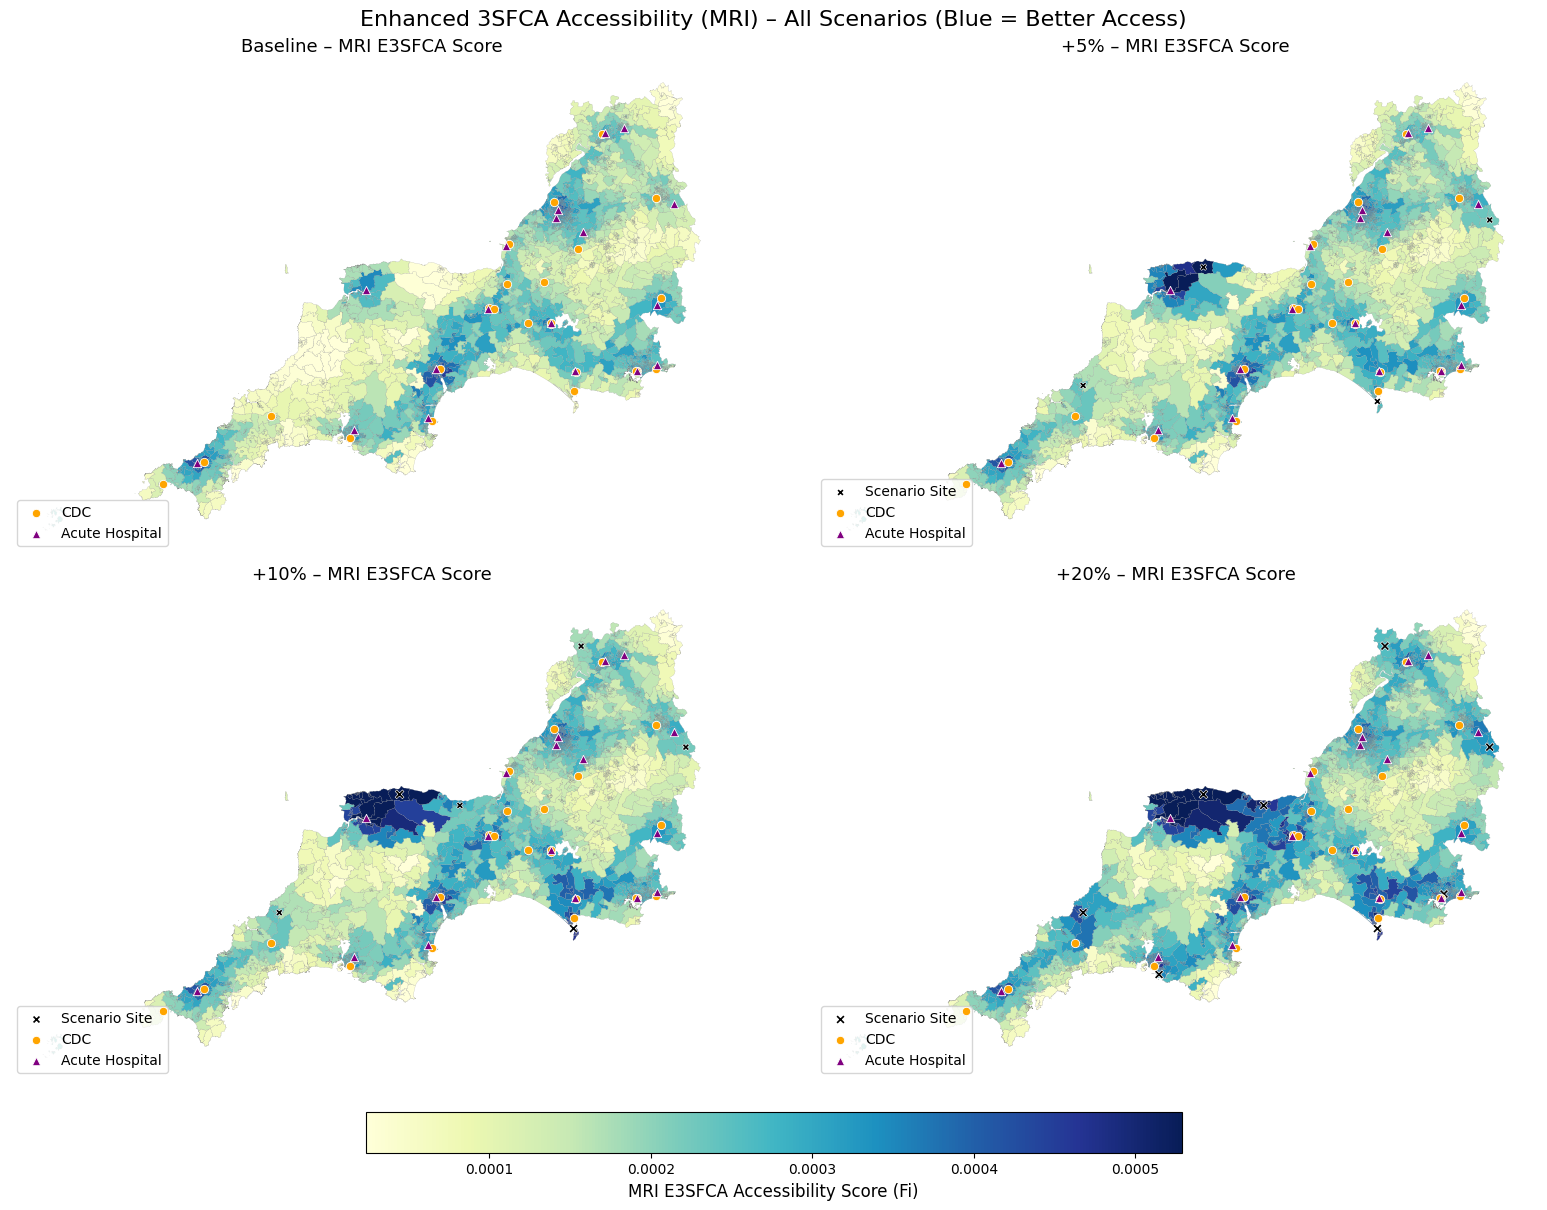

In [11]:
# ----------------------------------------------------------
# Step 8 – 2×2 Choropleth (Blue = Good, Green = Bad) + Facility & Scenario Overlays (MRI)
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Scenario -> MRI Fi column (from MRI Step 7/7a)
scenarios_plot = {
    "Baseline": "score_mri_baseline",     # if you only have enhanced_3sfca_score_mri, we handle that below
    "+5%":      "score_mri_plus5pct",
    "+10%":     "score_mri_plus10pct",
    "+20%":     "score_mri_plus20pct",
}

# Fallback: if score_mri_baseline isn't present, use enhanced_3sfca_score_mri
if "score_mri_baseline" not in gdf_lsoa.columns and "enhanced_3sfca_score_mri" in gdf_lsoa.columns:
    scenarios_plot["Baseline"] = "enhanced_3sfca_score_mri"

# Global colour scale across all panels
present_cols = [c for c in scenarios_plot.values() if c in gdf_lsoa.columns]
if present_cols:
    q1  = min(gdf_lsoa[c].quantile(0.01) for c in present_cols)
    q99 = max(gdf_lsoa[c].quantile(0.99) for c in present_cols)
    vmin = float(max(0.0, q1))
    vmax = float(q99)
else:
    vmin, vmax = 0.0, 0.0002  # fallback

cmap = "YlGnBu"   # Blue = better access
size_scale  = 12  # crosses
facility_ms = 36  # CDC/Acute markers

# Facilities (CSVs already include lsoa21cd) → join to LSOA polygons then centroid
cdc_gdf, acute_gdf = None, None

if 'cdc_path' in globals() and os.path.exists(cdc_path):
    cdc_df = pd.read_csv(cdc_path)
    if "lsoa21cd" in cdc_df.columns:
        cdc_df["lsoa21cd"] = cdc_df["lsoa21cd"].astype(str).str.strip()
        cdc_df = cdc_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        cdc_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(cdc_df, on="lsoa21cd", how="right")
        cdc_gdf = gpd.GeoDataFrame(cdc_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        cdc_gdf = cdc_gdf.set_geometry(cdc_gdf.geometry.centroid)

if 'acute_path' in globals() and os.path.exists(acute_path):
    acute_df = pd.read_csv(acute_path)
    if "lsoa21cd" in acute_df.columns:
        acute_df["lsoa21cd"] = acute_df["lsoa21cd"].astype(str).str.strip()
        acute_df = acute_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        acute_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(acute_df, on="lsoa21cd", how="right")
        acute_gdf = gpd.GeoDataFrame(acute_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        acute_gdf = acute_gdf.set_geometry(acute_gdf.geometry.centroid)

# Baseline LSOAs to exclude from crosses (Baseline scenario + facilities)
baseline_lsoa = set()
if 'scenario_site_data' in globals() and "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"].astype(str))
if isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# Plot loop
for ax, (label, score_col) in zip(axes.flat, scenarios_plot.items()):
    # Choropleth
    if score_col in gdf_lsoa.columns:
        gdf_lsoa.plot(
            column=score_col, cmap=cmap,
            linewidth=0.1, edgecolor="grey",
            legend=False, ax=ax,
            vmin=vmin, vmax=vmax,
            missing_kwds={"color": "lightgrey"},
        )
    else:
        gdf_lsoa.plot(color="lightgrey", linewidth=0.1, edgecolor="grey", ax=ax)

    # Scenario crosses (NEW-only vs baseline LSOAs)
    if 'scenario_site_data' in globals() and label in scenario_site_data:
        site_df = scenario_site_data[label].copy()
        if not site_df.empty:
            site_df["lsoa21cd"] = site_df["lsoa21cd"].astype(str)
            if baseline_lsoa:
                site_df = site_df[~site_df["lsoa21cd"].isin(baseline_lsoa)]
            if not site_df.empty:
                site_df = site_df.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
                site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
                site_gdf["geometry"] = site_gdf.geometry.centroid
                sizes = (
                    pd.to_numeric(site_gdf.get("scanner_count", 1), errors="coerce")
                      .fillna(1).astype(float) * size_scale
                )
                # White halo then black cross
                site_gdf.plot(ax=ax, marker="x", color="white",
                              markersize=sizes * 1.25, linewidth=2.0, alpha=1.0, zorder=4)
                site_gdf.plot(ax=ax, marker="x", color="black",
                              markersize=sizes, linewidth=1.2, alpha=1.0,
                              label="Scenario Site", zorder=5)

    # Facilities on top
    if isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
        cdc_gdf.plot(ax=ax, color="orange", marker="o", markersize=facility_ms,
                     edgecolor="white", linewidth=0.6, label="CDC", zorder=6)
    if isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
        acute_gdf.plot(ax=ax, color="purple", marker="^", markersize=facility_ms,
                       edgecolor="white", linewidth=0.6, label="Acute Hospital", zorder=7)

    ax.set_title(f"{label} – MRI E3SFCA Score", fontsize=13)
    ax.axis("off")

    # Clean legend per subplot
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        uniq = dict(zip(labels_, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="lower left", frameon=True)

# Shared colourbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal',
                    fraction=0.04, pad=0.03)
cbar.set_label("MRI E3SFCA Accessibility Score (Fi)", fontsize=12)

fig.suptitle("Enhanced 3SFCA Accessibility (MRI) – All Scenarios (Blue = Better Access)", fontsize=16)
fig.savefig("E3SFCA_MRI_scenarios_crosses_300dpi.png", dpi=300, bbox_inches="tight")
plt.show()


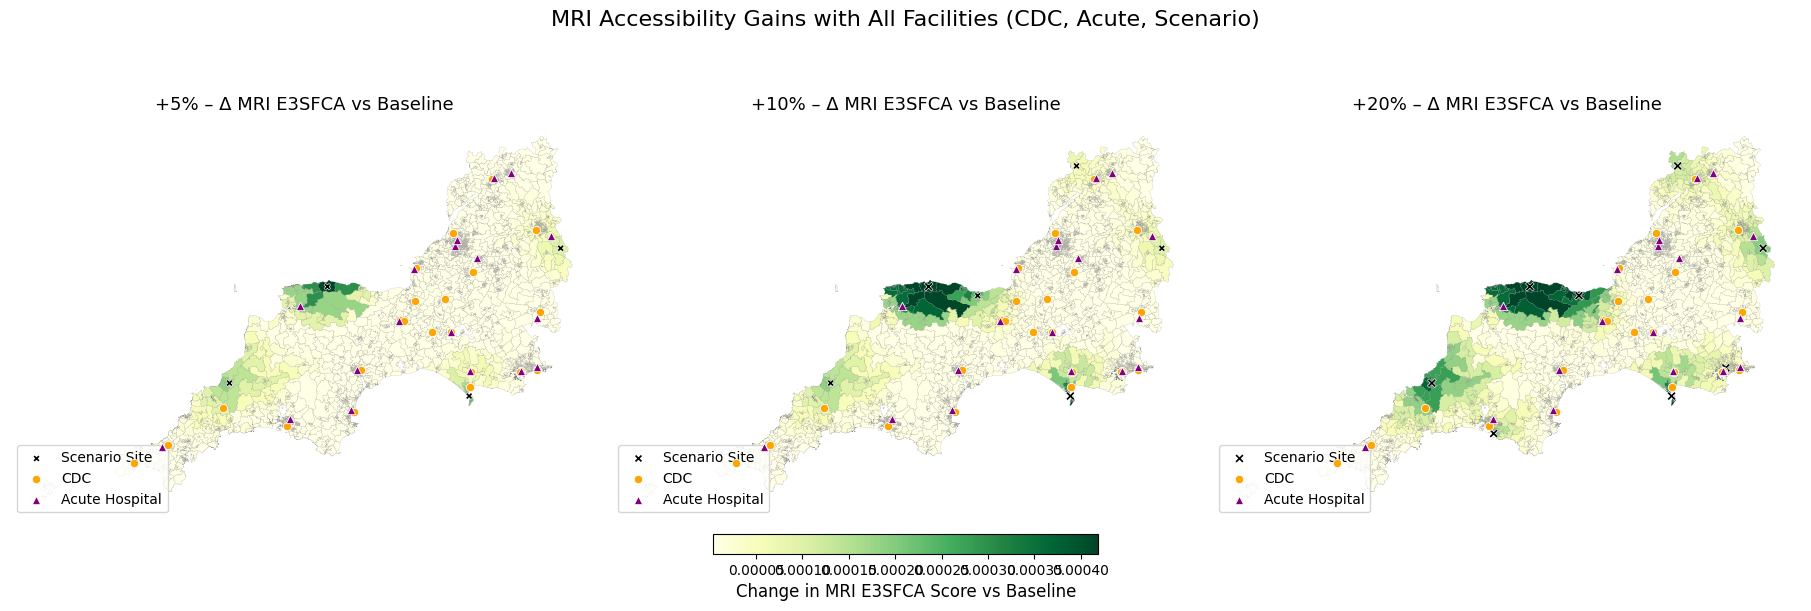

In [12]:
# ----------------------------------------------------------
# Step 8b – Delta Maps (MRI vs Baseline) + CDC (orange), Acute (purple), Scenario Crosses
# ----------------------------------------------------------

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Prefer MRI delta columns; fall back to generic if needed
_delta_candidates = {
    "+5%":  ["delta_mri_plus5pct",  "delta_plus5pct"],
    "+10%": ["delta_mri_plus10pct", "delta_plus10pct"],
    "+20%": ["delta_mri_plus20pct", "delta_plus20pct"],
}
delta_plot = {}
for lab, cand in _delta_candidates.items():
    delta_plot[lab] = next((c for c in cand if c in gdf_lsoa.columns), None)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Robust scale: compute percentiles from NON-ZERO deltas across all available cols
delta_cols_available = [c for c in delta_plot.values() if c is not None]
if delta_cols_available:
    vals = np.concatenate([gdf_lsoa[c].to_numpy(dtype=float) for c in delta_cols_available])
    nonzero = vals[np.isfinite(vals) & (np.abs(vals) > 0)]
    if nonzero.size > 0:
        vmin_delta = float(np.percentile(nonzero, 1))
        vmax_delta = float(np.percentile(nonzero, 99))
    else:
        vmin_delta, vmax_delta = 0.0, float(np.percentile(vals[np.isfinite(vals)], 99))
else:
    vmin_delta, vmax_delta = 0.0, 0.0  # fallback if no delta columns present

# Marker scaling
size_scale  = 12   # crosses
facility_ms = 36   # CDC/Acute marker size

# (Re)build facility GDFs if needed (expects CSVs with lsoa21cd)
if ('cdc_gdf' not in globals() or not isinstance(cdc_gdf, gpd.GeoDataFrame) or cdc_gdf.empty) and 'cdc_path' in globals() and os.path.exists(cdc_path):
    _cdc_df = pd.read_csv(cdc_path)
    if "lsoa21cd" in _cdc_df.columns:
        _cdc_df["lsoa21cd"] = _cdc_df["lsoa21cd"].astype(str).str.strip()
        _cdc_df = _cdc_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        cdc_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_cdc_df, on="lsoa21cd", how="right")
        cdc_gdf = gpd.GeoDataFrame(cdc_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        cdc_gdf = cdc_gdf.set_geometry(cdc_gdf.geometry.centroid)

if ('acute_gdf' not in globals() or not isinstance(acute_gdf, gpd.GeoDataFrame) or acute_gdf.empty) and 'acute_path' in globals() and os.path.exists(acute_path):
    _acute_df = pd.read_csv(acute_path)
    if "lsoa21cd" in _acute_df.columns:
        _acute_df["lsoa21cd"] = _acute_df["lsoa21cd"].astype(str).str.strip()
        _acute_df = _acute_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        acute_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_acute_df, on="lsoa21cd", how="right")
        acute_gdf = gpd.GeoDataFrame(acute_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        acute_gdf = acute_gdf.set_geometry(acute_gdf.geometry.centroid)

# Baseline LSOAs to exclude from crosses (Baseline scenario + facilities)
baseline_lsoa = set()
if 'scenario_site_data' in globals() and "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"].astype(str))
if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty and "lsoa21cd" in cdc_gdf.columns:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty and "lsoa21cd" in acute_gdf.columns:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# Plot panels
for ax, (label, delta_col) in zip(axes.flat, delta_plot.items()):
    # Choropleth (Green = accessibility gain)
    if delta_col and delta_col in gdf_lsoa.columns:
        gdf_lsoa.plot(
            column=delta_col,
            cmap="YlGn",
            linewidth=0.1,
            edgecolor="grey",
            legend=False,
            ax=ax,
            vmin=vmin_delta,
            vmax=vmax_delta,
            missing_kwds={"color": "lightgrey"}
        )
    else:
        gdf_lsoa.plot(color="lightgrey", linewidth=0.1, edgecolor="grey", ax=ax)

    # Scenario sites as black crosses with white halo (exclude baseline CDC/Acute/Baseline LSOAs)
    if 'scenario_site_data' in globals() and label in scenario_site_data:
        site_df = scenario_site_data[label].copy()
        if not site_df.empty:
            site_df["lsoa21cd"] = site_df["lsoa21cd"].astype(str)
            if baseline_lsoa:
                site_df = site_df[~site_df["lsoa21cd"].isin(baseline_lsoa)]
            if not site_df.empty:
                site_df = site_df.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
                site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
                site_gdf["geometry"] = site_gdf["geometry"].centroid
                sizes = pd.to_numeric(site_gdf.get("scanner_count", 1), errors="coerce").fillna(1).astype(float) * size_scale
                # White halo (underlay)
                site_gdf.plot(ax=ax, marker="x", color="white",
                              markersize=sizes * 1.25, linewidth=2.0, alpha=1.0, zorder=4)
                # Black cross (overlay)
                site_gdf.plot(ax=ax, marker="x", color="black",
                              markersize=sizes, linewidth=1.2, alpha=1.0,
                              label="Scenario Site", zorder=5)

    # Facilities LAST so they appear on top
    if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
        cdc_gdf.plot(ax=ax, color="orange", marker="o", markersize=facility_ms,
                     edgecolor="white", linewidth=0.6, label="CDC", zorder=6)
    if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
        acute_gdf.plot(ax=ax, color="purple", marker="^", markersize=facility_ms,
                       edgecolor="white", linewidth=0.6, label="Acute Hospital", zorder=7)

    ax.set_title(f"{label} – Δ MRI E3SFCA vs Baseline", fontsize=13)
    ax.axis("off")
    # Legend (dedupe)
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        uniq = dict(zip(labels_, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="lower left", frameon=True)

# Shared horizontal colourbar
sm = mpl.cm.ScalarMappable(cmap="YlGn", norm=mpl.colors.Normalize(vmin=vmin_delta, vmax=vmax_delta))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("Change in MRI E3SFCA Score vs Baseline", fontsize=12)

plt.suptitle("MRI Accessibility Gains with All Facilities (CDC, Acute, Scenario)", fontsize=16)

# Save at 300 DPI
fig.savefig("E3SFCA_MRI_delta_maps_300dpi.png", dpi=300, bbox_inches="tight")
plt.show()


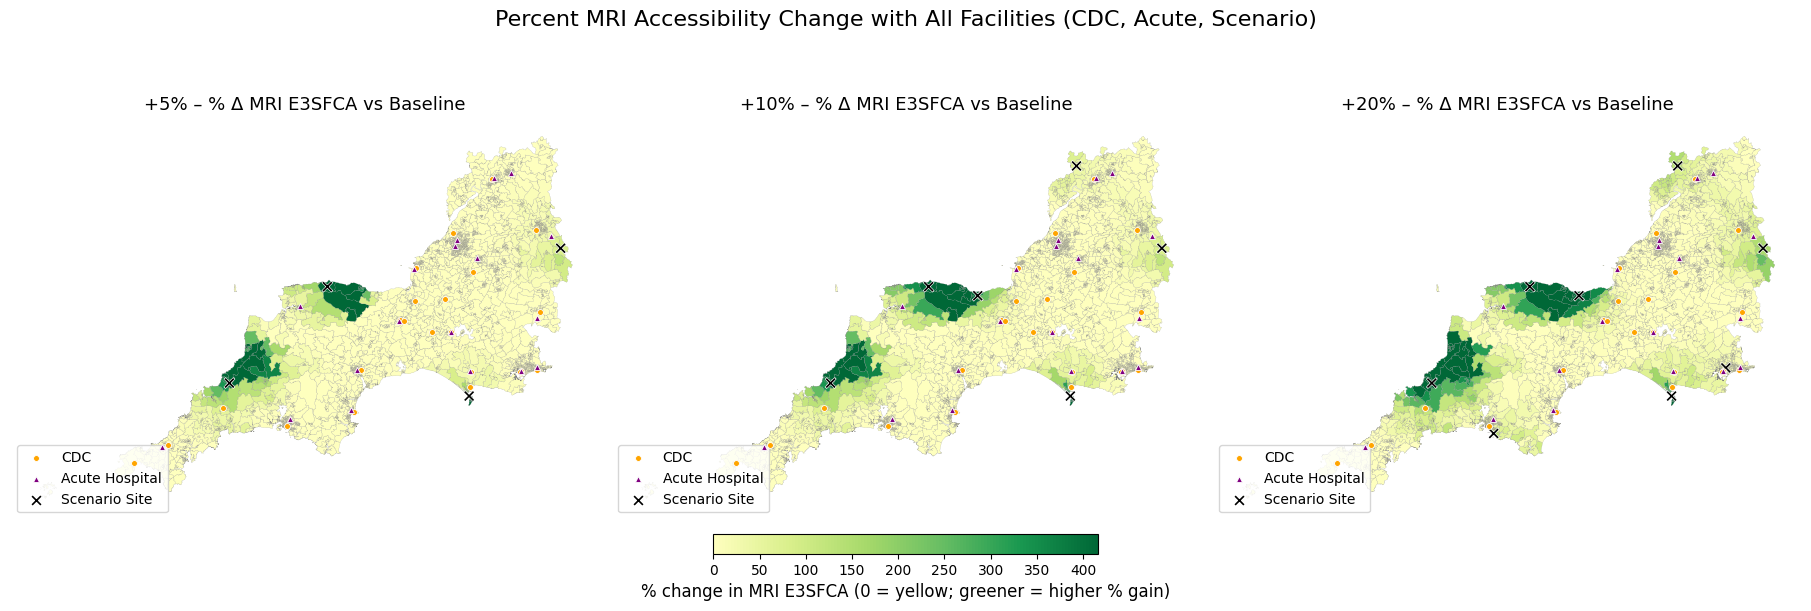

In [13]:
# ----------------------------------------------------------
# Step 8b – % Change Maps (MRI vs Baseline) + CDC (orange), Acute (purple), Scenario Crosses
# Icons 50% smaller; colourbar shows only +% with 0 as yellow
# ----------------------------------------------------------
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# --- Prefer MRI scenario score columns; fall back to generic if needed
_pref = {
    "+5%":  ["score_mri_plus5pct",  "score_plus5pct"],
    "+10%": ["score_mri_plus10pct", "score_plus10pct"],
    "+20%": ["score_mri_plus20pct", "score_plus20pct"],
}
scenarios_plot = {}
for lab, cand in _pref.items():
    scenarios_plot[lab] = next((c for c in cand if c in gdf_lsoa.columns), None)

# --- Pick the MRI baseline column first, then generic
baseline_candidates = [
    "score_mri_baseline",
    "enhanced_3sfca_score_mri",
    "Fi_mri", "fi_mri", "E3SFCA_MRI",
    # fallbacks:
    "score_baseline",
    "enhanced_3sfca_score_baseline",
    "enhanced_3sfca_score",
    "Fi", "fi", "E3SFCA",
]
baseline_col = next((c for c in baseline_candidates if c in gdf_lsoa.columns), None)
if baseline_col is None:
    raise KeyError("No MRI (or generic) baseline score column found in gdf_lsoa.")

# --- Ensure CDC/Acute GeoDataFrames exist from CSVs with `lsoa21cd`
if ('cdc_gdf' not in globals() or not isinstance(cdc_gdf, gpd.GeoDataFrame) or cdc_gdf.empty) \
   and 'cdc_path' in globals() and os.path.exists(cdc_path):
    _cdc = pd.read_csv(cdc_path)
    if "lsoa21cd" in _cdc.columns:
        _cdc["lsoa21cd"] = _cdc["lsoa21cd"].astype(str).str.strip()
        _cdc = _cdc.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        cdc_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_cdc, on="lsoa21cd", how="right")
        cdc_gdf = gpd.GeoDataFrame(cdc_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        cdc_gdf = cdc_gdf.set_geometry(cdc_gdf.geometry.centroid)

if ('acute_gdf' not in globals() or not isinstance(acute_gdf, gpd.GeoDataFrame) or acute_gdf.empty) \
   and 'acute_path' in globals() and os.path.exists(acute_path):
    _acute = pd.read_csv(acute_path)
    if "lsoa21cd" in _acute.columns:
        _acute["lsoa21cd"] = _acute["lsoa21cd"].astype(str).str.strip()
        _acute = _acute.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        acute_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_acute, on="lsoa21cd", how="right")
        acute_gdf = gpd.GeoDataFrame(acute_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        acute_gdf = acute_gdf.set_geometry(acute_gdf.geometry.centroid)

# --- % change per LSOA for each scenario vs baseline
pct_cols = {}
base = pd.to_numeric(gdf_lsoa[baseline_col], errors="coerce").astype(float)
for label, scen_col in scenarios_plot.items():
    if not scen_col:  # column missing
        continue
    scen = pd.to_numeric(gdf_lsoa[scen_col], errors="coerce").astype(float)
    pct_col = f"pct_mri_{label.lower().replace('+','plus').replace('%','pct')}"
    gdf_lsoa[pct_col] = np.where(base > 0, (scen - base) / base * 100.0, np.nan)
    pct_cols[label] = pct_col

# --- Diverging norm (RdYlGn centered at 0)
vals = np.concatenate([gdf_lsoa[c].to_numpy(dtype=float) for c in pct_cols.values()]) if pct_cols else np.array([0.0])
vals = vals[np.isfinite(vals)]
if vals.size == 0:
    vals = np.array([0.0])
low, high = np.percentile(vals, 1), np.percentile(vals, 99)
vabs = float(max(abs(low), abs(high), 1e-6))  # guard tiny ranges
map_norm = TwoSlopeNorm(vmin=-vabs, vcenter=0.0, vmax=vabs)

# --- Positive-only colourbar (0..+vabs), with 0 at yellow (upper half of RdYlGn)
_rdylgn = mpl.cm.get_cmap("RdYlGn")
pos_cmap = LinearSegmentedColormap.from_list("RdYlGn_pos", _rdylgn(np.linspace(0.5, 1.0, 256)))
pos_norm = mpl.colors.Normalize(vmin=0.0, vmax=vabs)

# --- Figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# --- Icon sizes (50% smaller)
size_scale = 12 * 0.5     # crosses
facility_ms = 36 * 0.5    # CDC/Acute markers
clip_min, clip_max = 40, 225

# --- Baseline LSOAs to suppress scenario crosses
baseline_lsoa = set()
if 'scenario_site_data' in globals() and "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"].astype(str))
if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty and "lsoa21cd" in cdc_gdf.columns:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty and "lsoa21cd" in acute_gdf.columns:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# --- Plot panels
for ax, (label, pct_col) in zip(axes.flat, pct_cols.items()):
    # Choropleth (% change, diverging, centered at 0)
    gdf_lsoa.plot(
        column=pct_col, cmap="RdYlGn", norm=map_norm,
        linewidth=0.1, edgecolor="grey", legend=False, ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    # Facilities
    if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
        cdc_gdf.plot(ax=ax, color="orange", marker="o", markersize=facility_ms,
                     edgecolor="white", linewidth=0.6, label="CDC", zorder=6)
    if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
        acute_gdf.plot(ax=ax, color="purple", marker="^", markersize=facility_ms,
                       edgecolor="white", linewidth=0.6, label="Acute Hospital", zorder=7)

    # Scenario crosses (exclude baseline LSOAs)
    if 'scenario_site_data' in globals() and label in scenario_site_data:
        site_df = scenario_site_data[label].copy()
        if not site_df.empty:
            site_df["lsoa21cd"] = site_df["lsoa21cd"].astype(str)
            if baseline_lsoa:
                site_df = site_df[~site_df["lsoa21cd"].isin(baseline_lsoa)]
            if not site_df.empty:
                site_df = site_df.merge(gdf_lsoa[["lsoa21cd","geometry"]], on="lsoa21cd", how="left")
                site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
                site_gdf["geometry"] = site_gdf.geometry.centroid
                ms_sites = (
                    pd.to_numeric(site_gdf.get("scanner_count", 1), errors="coerce").fillna(1).astype(float)
                    * size_scale
                ).clip(clip_min, clip_max)

                # White halo (underlay)
                site_gdf.plot(ax=ax, marker="x", color="white",
                              markersize=ms_sites * 1.25, linewidth=2.0, alpha=1.0, zorder=4)
                # Black cross (overlay)
                site_gdf.plot(ax=ax, marker="x", color="black",
                              markersize=ms_sites, linewidth=1.2, alpha=1.0,
                              label="Scenario Site", zorder=5)

    ax.set_title(f"{label} – % Δ MRI E3SFCA vs Baseline", fontsize=13)
    ax.axis("off")
    # Dedupe legend per subplot
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        uniq = dict(zip(labels_, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="lower left", frameon=True)

# --- Positive-only colourbar (0..+vabs), with 0 as yellow
sm_pos = mpl.cm.ScalarMappable(cmap=pos_cmap, norm=pos_norm)
sm_pos._A = []
cbar = fig.colorbar(sm_pos, ax=axes.ravel().tolist(),
                    orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("% change in MRI E3SFCA (0 = yellow; greener = higher % gain)", fontsize=12)

plt.suptitle("Percent MRI Accessibility Change with All Facilities (CDC, Acute, Scenario)", fontsize=16)

# --- Save @300 DPI
out_path = "Step8b_MRI_percent_change_maps_300dpi.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


In [14]:
# --- Quick summary: how many LSOAs improved/worsened/unchanged (by scenario) ---

import numpy as np
import pandas as pd

# Preferred scenario order
_scenarios = ["+5%", "+10%", "+20%"]

# Prefer MRI % change; fall back to generic %; else MRI delta; else generic delta
def _pick_col(cands):
    return next((c for c in cands if c in gdf_lsoa.columns), None)

_pct_pref = {
    "+5%":  ["pct_mri_plus5pct",  "pct_plus5pct"],
    "+10%": ["pct_mri_plus10pct", "pct_plus10pct"],
    "+20%": ["pct_mri_plus20pct", "pct_plus20pct"],
}
_delta_pref = {
    s: [f"delta_mri_{s.lower().replace('+','plus').replace('%','pct')}",
        f"delta_{s.lower().replace('+','plus').replace('%','pct')}"]
    for s in _scenarios
}

pct_available   = {k: _pick_col(v) for k, v in _pct_pref.items() if _pick_col(v)}
delta_available = {k: _pick_col(v) for k, v in _delta_pref.items() if _pick_col(v)}

if pct_available:
    change_cols = pct_available
    units = "%"
    tol   = globals().get("change_tol_pct", 0.001)  # treat |Δ|<=0.001% as unchanged
    print(f"Using % change columns (MRI-preferred): {change_cols}")
elif delta_available:
    change_cols = delta_available
    units = "ΔFi"
    tol   = globals().get("change_tol_abs", 1e-12)  # near-zero in absolute units
    print(f"Using delta columns (MRI-preferred): {change_cols}")
else:
    raise KeyError("No percent-change (pct_mri_* or pct_*) or delta (delta_mri_* or delta_*) columns found in gdf_lsoa.")

# 2) Build summary per scenario
rows = []
for label in _scenarios:
    if label not in change_cols:
        continue
    col = change_cols[label]
    s = pd.to_numeric(gdf_lsoa[col], errors="coerce")
    n_total = int(len(s))
    n = int(s.notna().sum())
    n_na = n_total - n

    improved  = int((s >  tol).sum())
    worsened  = int((s < -tol).sum())
    unchanged = int((s.abs() <= tol).sum())

    rows.append({
        "Scenario": label,
        "LSOAs (total)": n_total,
        "LSOAs (valid)": n,
        "NA (n)": n_na,
        "NA (%)": (n_na / n_total * 100) if n_total else np.nan,
        "Improved (n)": improved,
        "Improved (%)": (improved / n * 100) if n else np.nan,
        "Worsened (n)": worsened,
        "Worsened (%)": (worsened / n * 100) if n else np.nan,
        "Unchanged (n)": unchanged,
        "Unchanged (%)": (unchanged / n * 100) if n else np.nan,
        "Net (Improved − Worsened)": improved - worsened,
        "Mean change": s.mean(),
        "Median change": s.median(),
        "P10": s.quantile(0.10),
        "P90": s.quantile(0.90),
        "Min": s.min(),
        "Max": s.max(),
        "Units": units,
        "Tolerance used": tol,
        "Column": col,
    })

df_change_summary = pd.DataFrame(rows)

# 3) Tidy formatting
pct_cols = ["NA (%)", "Improved (%)", "Worsened (%)", "Unchanged (%)"]
for c in pct_cols:
    if c in df_change_summary.columns:
        df_change_summary[c] = df_change_summary[c].round(2)

stat_cols = ["Mean change", "Median change", "P10", "P90", "Min", "Max"]
if units == "%":
    df_change_summary[stat_cols] = df_change_summary[stat_cols].round(2)
else:
    df_change_summary[stat_cols] = df_change_summary[stat_cols].round(6)

# 4) Display
try:
    from IPython.display import display
    display(df_change_summary)
except Exception:
    print(df_change_summary.to_string(index=False))


Using % change columns (MRI-preferred): {'+5%': 'pct_mri_plus5pct', '+10%': 'pct_mri_plus10pct', '+20%': 'pct_mri_plus20pct'}


,Scenario,LSOAs (total),LSOAs (valid),NA (n),NA (%),Improved (n),Improved (%),Worsened (n),Worsened (%),Unchanged (n),...,Net (Improved − Worsened),Mean change,Median change,P10,P90,Min,Max,Units,Tolerance used,Column
0,+5%,3451,3451,0,0.0,899,26.05,0,0.0,2552,...,899,13.78,0.00,0.0,25.74,0.0,1830.92,%,0.001,pct_mri_plus5pct
1,+10%,3451,3451,0,0.0,1485,43.03,0,0.0,1966,...,1485,25.34,0.00,0.0,34.32,0.0,3947.60,%,0.001,pct_mri_plus10pct
2,+20%,3451,3451,0,0.0,2132,61.78,0,0.0,1319,...,2132,43.91,10.11,0.0,64.66,0.0,4781.06,%,0.001,pct_mri_plus20pct


In [15]:
# ----------------------------------------------------------
# Step 9 – Summary Statistics for E3SFCA Scores and Δ Improvements (MRI-first)
# (robust to missing columns; includes Baseline in score summaries)
# ----------------------------------------------------------
import pandas as pd
import numpy as np

# --- 0) Helper: tidy describe into a row dict
def _summ_row(name, s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    desc = s.describe(percentiles=[0.25, 0.5, 0.75])
    return {
        "Scenario": name,
        "Count (valid)": int(desc.get("count", 0)),
        "NA (n)": int(s.isna().sum()),
        "Mean": float(desc.get("mean", np.nan)),
        "Median": float(desc.get("50%", np.nan)),
        "Min": float(desc.get("min", np.nan)),
        "Q1": float(desc.get("25%", np.nan)),
        "Q3": float(desc.get("75%", np.nan)),
        "Max": float(desc.get("max", np.nan)),
        "Std Dev": float(desc.get("std", np.nan)),
    }

def _first_present(cands):
    return next((c for c in cands if c in gdf_lsoa.columns), None)

# --- 1) Find baseline score column (MRI-first, then generic)
baseline_pref_mri = [
    "score_mri_baseline",
    "enhanced_3sfca_score_mri_baseline",
    "enhanced_3sfca_score_mri",
]
baseline_pref_generic = [
    "score_baseline",
    "enhanced_3sfca_score_baseline",
    "enhanced_3sfca_score",
    "Fi", "fi", "E3SFCA",
]
baseline_col = _first_present(baseline_pref_mri) or _first_present(baseline_pref_generic)
if baseline_col is None:
    raise KeyError(f"No baseline score column found. Have: {list(gdf_lsoa.columns)}")

# --- 2) Build scenario→column map safely (MRI-first; fall back to generic)
mri_scores = {
    "Baseline": baseline_col,  # whatever we picked above
    "+5%":      "score_mri_plus5pct",
    "+10%":     "score_mri_plus10pct",
    "+20%":     "score_mri_plus20pct",
}
generic_scores = {
    "Baseline": baseline_col,
    "+5%":      "score_plus5pct",
    "+10%":     "score_plus10pct",
    "+20%":     "score_plus20pct",
}
scenarios_plot_use = {}
for k in ["Baseline", "+5%", "+10%", "+20%"]:
    pref = mri_scores[k]
    alt  = generic_scores[k]
    if pref in gdf_lsoa.columns:
        scenarios_plot_use[k] = pref
    elif alt in gdf_lsoa.columns:
        scenarios_plot_use[k] = alt
# (Baseline will always be present because it's baseline_col)

# --- 3) Absolute score summaries (print baseline + each scenario present)
print("\n--- E3SFCA Score Summary ---")
print("\nBaseline")
print(pd.to_numeric(gdf_lsoa[baseline_col], errors="coerce")
        .describe(percentiles=[0.25, 0.5, 0.75]).round(6))

for label, col in scenarios_plot_use.items():
    if label == "Baseline":
        continue
    print(f"\n{label}")
    print(pd.to_numeric(gdf_lsoa[col], errors="coerce")
            .describe(percentiles=[0.25, 0.5, 0.75]).round(6))

# --- 4) Δ score summaries (vs baseline) – MRI-first; fall back to generic if needed
delta_pref = {
    "+5%":  ["delta_mri_plus5pct",  "delta_plus5pct"],
    "+10%": ["delta_mri_plus10pct", "delta_plus10pct"],
    "+20%": ["delta_mri_plus20pct", "delta_plus20pct"],
}
delta_plot_use = {k: _first_present(v) for k, v in delta_pref.items() if _first_present(v)}

if delta_plot_use:
    print("\n--- Δ E3SFCA vs Baseline Summary ---")
    for label, delta_col in delta_plot_use.items():
        print(f"\n{label}")
        print(pd.to_numeric(gdf_lsoa[delta_col], errors="coerce")
                .describe(percentiles=[0.25, 0.5, 0.75]).round(6))

# --- 5) Summary table for absolute scores (with Baseline row)
rows_scores = []
rows_scores.append(_summ_row("Baseline", gdf_lsoa[baseline_col]))
for label, col in scenarios_plot_use.items():
    if label == "Baseline":
        continue
    rows_scores.append(_summ_row(label, gdf_lsoa[col]))
df_scores_summary = pd.DataFrame(rows_scores).round(6)

# --- 6) Summary table for deltas (if present; baseline not applicable)
df_deltas_summary = None
if delta_plot_use:
    rows_deltas = []
    for label, col in delta_plot_use.items():
        rows_deltas.append(_summ_row(label, gdf_lsoa[col]))
    df_deltas_summary = pd.DataFrame(rows_deltas).round(6)

# --- 7) Percent-change summaries if pct_* columns exist (MRI-first)
pct_pref = {
    "+5%":  ["pct_mri_plus5pct",  "pct_plus5pct"],
    "+10%": ["pct_mri_plus10pct", "pct_plus10pct"],
    "+20%": ["pct_mri_plus20pct", "pct_plus20pct"],
}
pct_map_use = {k: _first_present(v) for k, v in pct_pref.items() if _first_present(v)}
df_pct_summary = None
if pct_map_use:
    rows_pct = []
    for label, col in pct_map_use.items():
        rows_pct.append(_summ_row(label, gdf_lsoa[col]))
    df_pct_summary = pd.DataFrame(rows_pct).round(2)  # % values—2dp is fine

# --- 8) Display nicely
try:
    from IPython.display import display
    print("\n\n=== Table: E3SFCA Scores (Absolute) ===")
    display(df_scores_summary)
    if df_deltas_summary is not None:
        print("\n=== Table: Δ E3SFCA vs Baseline ===")
        display(df_deltas_summary)
    if df_pct_summary is not None:
        print("\n=== Table: % Change vs Baseline ===")
        display(df_pct_summary)
except Exception:
    print("\n\n=== Table: E3SFCA Scores (Absolute) ===")
    print(df_scores_summary.to_string(index=False))
    if df_deltas_summary is not None:
        print("\n=== Table: Δ E3SFCA vs Baseline ===")
        print(df_deltas_summary.to_string(index=False))
    if df_pct_summary is not None:
        print("\n=== Table: % Change vs Baseline ===")
        print(df_pct_summary.to_string(index=False))



--- E3SFCA Score Summary ---

Baseline
count    3451.000000
mean        0.000221
std         0.000090
min         0.000005
25%         0.000159
50%         0.000226
75%         0.000284
max         0.000514
Name: score_mri_baseline, dtype: float64

+5%
count    3451.000000
mean        0.000232
std         0.000088
min         0.000010
25%         0.000174
50%         0.000238
75%         0.000289
max         0.000703
Name: score_mri_plus5pct, dtype: float64

+10%
count    3451.000000
mean        0.000244
std         0.000100
min         0.000010
25%         0.000179
50%         0.000250
75%         0.000298
max         0.001312
Name: score_mri_plus10pct, dtype: float64

+20%
count    3451.000000
mean        0.000269
std         0.000107
min         0.000010
25%         0.000196
50%         0.000274
75%         0.000339
max         0.001321
Name: score_mri_plus20pct, dtype: float64

--- Δ E3SFCA vs Baseline Summary ---

+5%
count    3451.000000
mean        0.000012
std         0.000033

,Scenario,Count (valid),NA (n),Mean,Median,Min,Q1,Q3,Max,Std Dev
0,Baseline,3451,0,0.000221,0.000226,0.000005,0.000159,0.000284,0.000514,0.000090
1,+5%,3451,0,0.000232,0.000238,0.000010,0.000174,0.000289,0.000703,0.000088
2,+10%,3451,0,0.000244,0.000250,0.000010,0.000179,0.000298,0.001312,0.000100
3,+20%,3451,0,0.000269,0.000274,0.000010,0.000196,0.000339,0.001321,0.000107



=== Table: Δ E3SFCA vs Baseline ===


,Scenario,Count (valid),NA (n),Mean,Median,Min,Q1,Q3,Max,Std Dev
0,+5%,3451,0,0.000012,0.000000,0.0,0.0,0.000005,0.000599,0.000033
1,+10%,3451,0,0.000024,0.000000,0.0,0.0,0.000028,0.001207,0.000063
2,+20%,3451,0,0.000048,0.000019,0.0,0.0,0.000077,0.001217,0.000076



=== Table: % Change vs Baseline ===


,Scenario,Count (valid),NA (n),Mean,Median,Min,Q1,Q3,Max,Std Dev
0,+5%,3451,0,13.78,0.00,0.0,0.0,2.19,1830.92,76.81
1,+10%,3451,0,25.34,0.00,0.0,0.0,14.52,3947.60,146.25
2,+20%,3451,0,43.91,10.11,0.0,0.0,34.57,4781.06,202.68
